In [29]:
# check versions and devices
print("python version: ", sys.version)
# print("tf version: ", tf.__version__)
# print("devices: ", tf.config.list_physical_devices())

python version:  3.9.13 (main, Oct 13 2022, 16:12:30) 
[Clang 12.0.0 ]


In [30]:
# convert annotations to dataframes to visualize classes
from pandas import DataFrame
from scipy.io import loadmat
mat = loadmat('data/info.mat')
cars = DataFrame(mat['class_names'][0])
boxes = DataFrame(mat['annotations'][0])
# print("cars:\n", cars.head())
# print("boxes:\n", boxes.head())

In [31]:
# organize images into directories
import os
import shutil
imlist = os.listdir("./data/images/")
for i in range(len(imlist)):
    img_num = int(imlist[i].split('.')[0])
    dir_num = int(boxes['class'][img_num-1][0][0]-1)
    img_path = os.path.join("./data/images/", imlist[i])
    dir_path = os.path.join("./data/dataset/", str(dir_num)+"/"+imlist[i])
    shutil.move(img_path, dir_path)

In [32]:
# create train and validation datasets
import tensorflow as tf

batch_size = 126
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
# TODO: figure out why not sorted
# print("class names: ", class_names)

Found 16185 files belonging to 196 classes.
Using 12948 files for training.
Found 16185 files belonging to 196 classes.
Using 3237 files for validation.


In [33]:
# configure performance
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [34]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(196)
])

model.summary()



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 32)      

In [35]:
# compile model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [36]:
# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


2022-10-30 02:24:53.115847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 5.2477 - accuracy: 0.0065

2022-10-30 02:26:48.969620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 141s 1s/step - loss: 5.2477 - accuracy: 0.0065 - val_loss: 5.1866 - val_accuracy: 0.0108
Epoch 2/3
103/103 [==============================] - 133s 1s/step - loss: 5.0992 - accuracy: 0.0186 - val_loss: 5.1230 - val_accuracy: 0.0207
Epoch 3/3
103/103 [==============================] - 130s 1s/step - loss: 4.7682 - accuracy: 0.0525 - val_loss: 5.1871 - val_accuracy: 0.0269


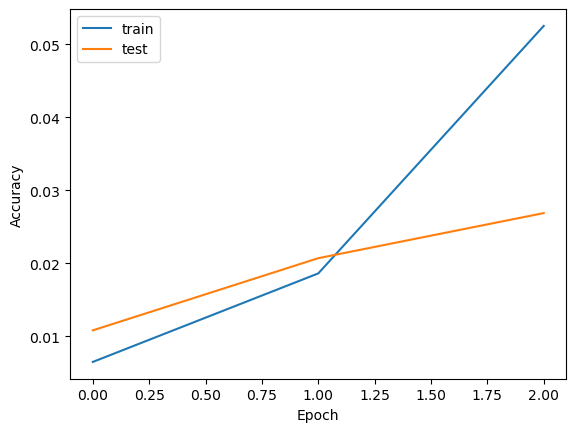

In [37]:
# plot accuracy and val_accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()